In [28]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor


In [30]:
# Load the data
data = pd.read_csv('processed_cancer_care_data.csv')

# Drop any rows with missing values
data = data.dropna()

# Separate features (X) and target variable (y)
X = data.drop(columns=['total_costs', 'last_year_cost'])
y = data['last_year_cost']

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Define models
models = {
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=100),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100, objective='reg:squarederror'),
    "LightGBM": LGBMRegressor(random_state=42, n_estimators=100),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

# Define tolerance for custom accuracy
tolerance = 0.1  # 10% tolerance

# Function to calculate custom accuracy
def custom_accuracy(y_true, y_pred, tolerance):
    return np.mean(np.abs(y_true - y_pred) / y_true < tolerance) * 100

# Initialize dictionary to store results
model_scores = {}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    custom_acc = custom_accuracy(y_test, y_pred, tolerance)

    model_scores[model_name] = {"RMSE": rmse, "MAE": mae, "Custom Accuracy (10% tolerance)": custom_acc}
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, Custom Accuracy (10% tolerance): {custom_acc:.2f}%")


RandomForest - RMSE: 214.12, MAE: 82.54, Custom Accuracy (10% tolerance): 98.01%
XGBoost - RMSE: 189.90, MAE: 83.69, Custom Accuracy (10% tolerance): 97.21%
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 32
[LightGBM] [Info] Start training from score 5020.766890
LightGBM - RMSE: 383.57, MAE: 147.92, Custom Accuracy (10% tolerance): 91.63%
KNN - RMSE: 614.39, MAE: 309.69, Custom Accuracy (10% tolerance): 72.51%



Model Performance Comparison:
                     RMSE         MAE  Custom Accuracy (10% tolerance)
RandomForest  214.121539   82.542793                        98.007968
XGBoost       189.902576   83.691941                        97.211155
LightGBM      383.568043  147.915519                        91.633466
KNN           614.391848  309.692351                        72.509960


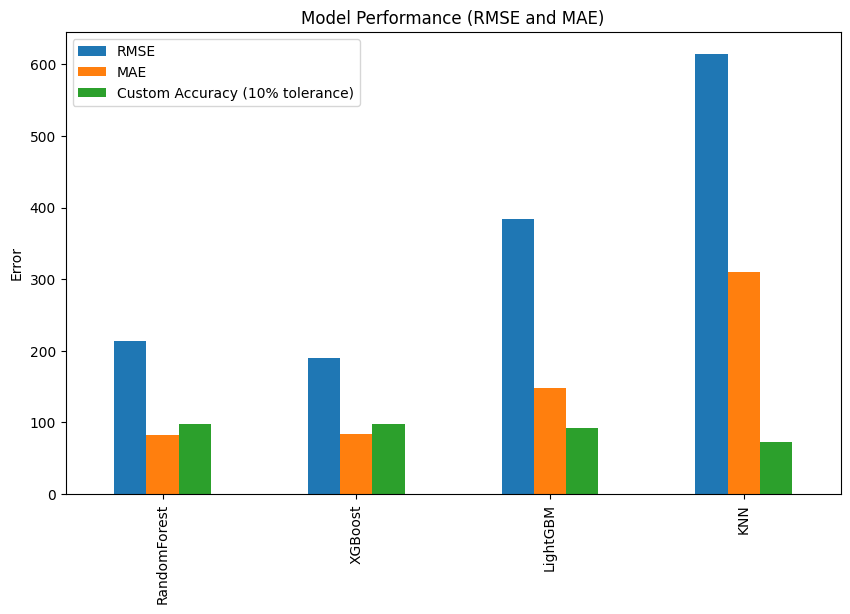

Best model (XGBoost) saved as 'XGBoost_model.pkl'.


In [32]:
# Display model performance comparison
model_performance = pd.DataFrame(model_scores).T
print("\nModel Performance Comparison:\n", model_performance)

# Optional: Plot model performance
model_performance.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance (RMSE and MAE)")
plt.ylabel("Error")
plt.show()

# Save the best model based on RMSE
best_model_name = model_performance['RMSE'].idxmin()
best_model = models[best_model_name]
pickle.dump(best_model, open(f'{best_model_name}_model.pkl', 'wb'))
print(f"Best model ({best_model_name}) saved as '{best_model_name}_model.pkl'.")